# Exercise 3: Ising Model

## Coding Ising model using Metropolis-Hastings algorithm

In [1]:
"""Importing relevant modules"""

import numpy.random as random
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
"""Defining some relevant functions"""


def initialise_random_array(w: float) -> np.ndarray:
    """Creates a 'w x w' square array with values -1 or 1 assigned randomly'

    """
    random_array = np.random.randint(0, 2, (w, w))
    random_array[random_array == 0] = -1
    return random_array


def initialise_up_array(w: float) -> np.ndarray:
    """Creates a 'w x w' square array with all values equal to 1


    """
    ones_array = np.ones((w, w))
    return ones_array


def visualise_array(input_array: np.ndarray,title:str):
    """prints a formatted heatmap of the input array
    """
    plt.matshow(input_array,cmap='gray')
    plt.axis("off")
 
    plt.title(title)
    plt.show()

- I will use the dimensionless quantites $\beta J$ and $\beta \mu H$ for all the relveant calculations. In the code they will be labelled as:
- $\beta J$= coupling_field
- $\beta \mu H$ = external_field

- For the external field interaction: $E\propto$ the sum of the array values, for each spin flip this sum will only change by $\pm 2$ therefore the change in energy (multiplied by $\beta$) to flip a spin $s_i$ is equal to:
$$2s_i\beta \mu H$$

- Similarly for coupling interaction, take the sum of all nearest neighbour spins to be $k$. Change in energy will be:
$$2s_i\beta Jk$$

- Total energy change for flipping a single spin is given by:
$$\beta\Delta E = 2s_i(\beta Jk+\beta \mu H)$$



To improve code performance, the entire algorithm will be carried out using numpy vectorized functions rather than iterating through every position in the array.
As suggested in the hints for this exercise, this will require updating all alternating spins simultaneously.

For each iteration:
1.  Calculate a $w*w$ array which gives the sum of all nearest neighbours of each spin (k values)
2.  Use this to create a $w*w$ array of $\Delta E$ values that correspond to flipping each individual spin (with all other spins constant).
3.  Use np.exp to calculate an array with the probabilities for each spin flip
4.  Subtract from this probabiliy array a $w*w$ array of random p values uniformly generated between 0 and 1 (if the values of this final array are positive then the corresponding spin will flip, otherwise the spin doesn't flip). Convert to boolean array with true for values greater than 0.
6. Use a boolean mask that is only true for alternating positions in the array and combine the two boolean arrays.
7. Convert this final array from True->(-1), False->(+1) and multiply intial array by this array.

8. Repeat steps 1-7 but with the oppostie boolean mask for alternating positions.


In [3]:
def generate_k_matrix(input_array: np.ndarray) -> np.ndarray:
    """Generates a w*w matrix of the sum of all nearest neighbours"""
    return (
        np.roll(input_array, 1, axis=1)
        + np.roll(input_array, -1, axis=1)
        + np.roll(input_array, 1, axis=0)
        + np.roll(input_array, -1, axis=0)
    )


def generate_E_matrix(
    input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    """Generates a w*w matrix that contains the change in energy (multiplied by beta) associated with flipping each spin"""
    k_matrix = generate_k_matrix(input_array)
    E_coupling = 2 * coupling_field * np.multiply(input_array, k_matrix)
    E_external = 2 * np.multiply(input_array, external_field)
    E_matrix = E_coupling + E_external
    return E_matrix


def generate_prob_matrix(
    input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    """Generates a matrix with values corresponding to the probability of the associated spin flipping"""
    return np.exp(-1 * generate_E_matrix(input_array, coupling_field, external_field))


def check_flip(
    input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    """Generates a matrix with boolean values corresponding to whether the associated spin will flip
    - True:flip
    -False: No flip"""
    p_matrix = random.random(
        np.shape(input_array)
    )  # uniform random numbers between 0 and 1
    prob_matrix = generate_prob_matrix(input_array, coupling_field, external_field)
    difference = np.subtract(prob_matrix, p_matrix)
    boolean_matrix = difference > 0
    return boolean_matrix


def mask_even(input_array: np.ndarray) -> np.ndarray:
    """Creates a boolean array with true values at alternating positions i.e. where the sum of the indices is even"""
    return np.indices(input_array.shape).sum(axis=0) % 2 == 0


def mask_odd(input_array: np.ndarray) -> np.ndarray:
    """Creates a boolean array with true values at alternating positions i.e. where the sum of the indices is odd"""
    return np.indices(input_array.shape).sum(axis=0) % 2 == 1


def update_spins_even(
    input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    """Updates the spin of all sites where the sum of the indices are even"""
    update_matrix = mask_even(input_array) * check_flip(
        input_array, coupling_field, external_field
    )
    opposite_matrix = ~update_matrix
    update_matrix_1 = update_matrix * (-1)
    update_matrix_2 = opposite_matrix * 1
    updated_array = np.add(update_matrix_2, update_matrix_1)
    return updated_array


def update_spins_odd(
    input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    """Updates the spin of all sites where the sum of the indices are odd"""
    update_matrix = mask_odd(input_array) * check_flip(
        input_array, coupling_field, external_field
    )
    opposite_matrix = ~update_matrix
    update_matrix_1 = update_matrix * (-1)
    update_matrix_2 = opposite_matrix * 1
    updated_array = np.add(update_matrix_2, update_matrix_1)
    return updated_array


def do_complete_iteration(
    input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    new_array_even = input_array * update_spins_even(
        input_array, coupling_field, external_field
    )

    new_array_odd = new_array_even * update_spins_odd(
        new_array_even, coupling_field, external_field
    )

    return new_array_odd


def calc_magnetisation(input_array: np.ndarray) -> float:
    """Calculates the magnetisation of the input array"""
    return np.sum(input_array) / np.size(input_array)


def run_N_iterations(
    N: float, input_array: np.ndarray, coupling_field: float, external_field: float
) -> np.ndarray:
    counter = 0
    visualise_array(input_array, "Initial Array")
    magnetisation = np.zeros(N + 1)
    magnetisation[0] = calc_magnetisation(input_array)
    for i in range(N):

        input_array = do_complete_iteration(input_array, coupling_field, external_field)
        counter += 1
        magnetisation[i + 1] = calc_magnetisation(input_array)

        if np.log10(counter) % 1 == 0:
            title = f"{counter} Iterations"
            visualise_array(input_array, title)
    return np.arange(N + 1), magnetisation

## Core Task 1: No Spin Coupling
- Use Metropolis‑Hastings algorithm to evolve a 2D lattice with periodic boundary conditions and no spin-spin interactions
- Compute relative magnetisation for a variety of evolutions (min. 10,000) with a variety of initial conditions
- Plot magnetisation and compare to analytical expression

### External Field = -3

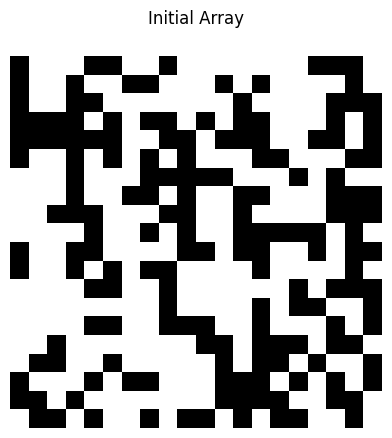

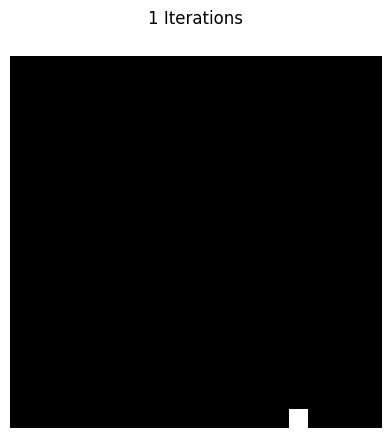

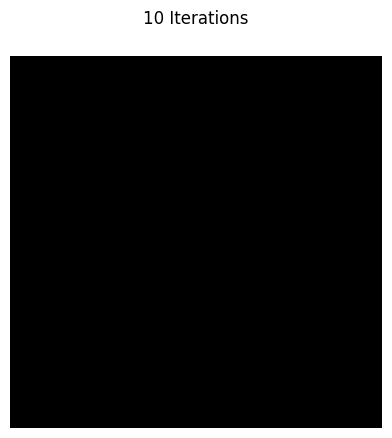

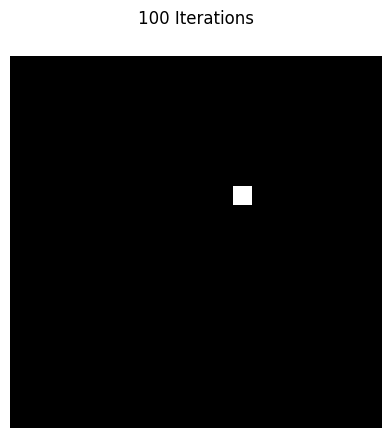

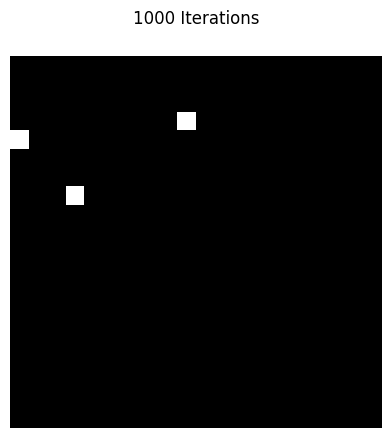

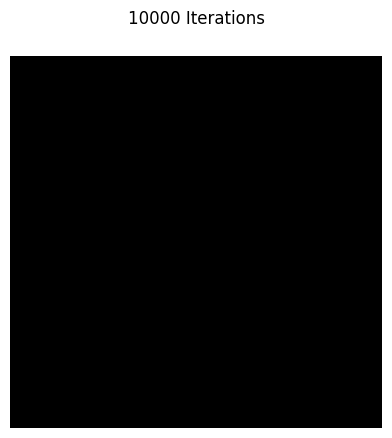

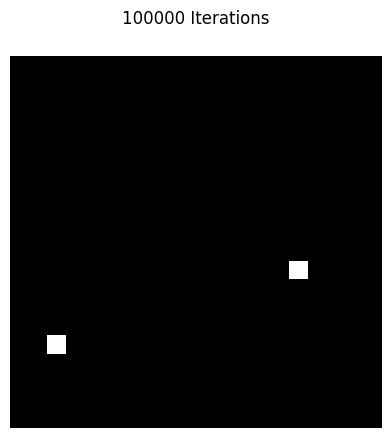

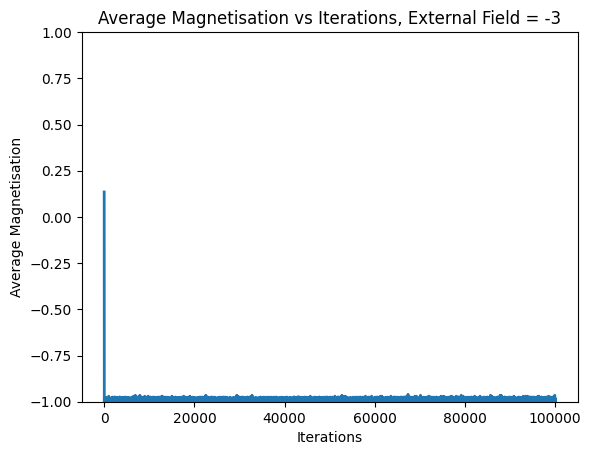

In [4]:
plt.plot(*run_N_iterations(100000, initialise_random_array(20), 0, -3),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = -3")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = -0.5

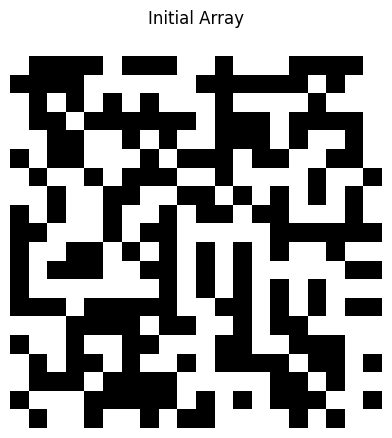

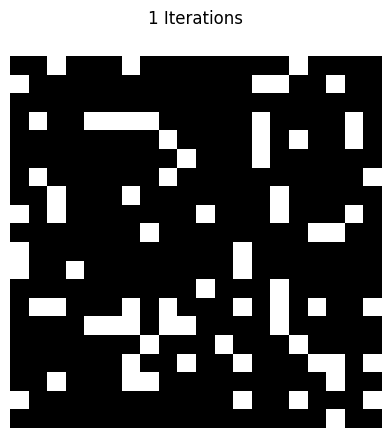

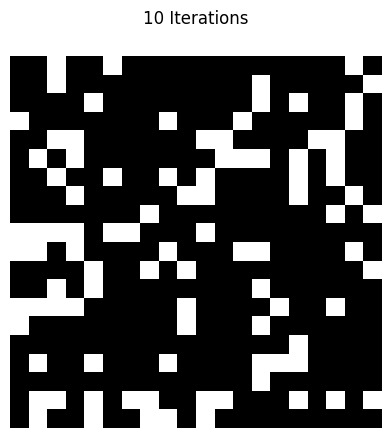

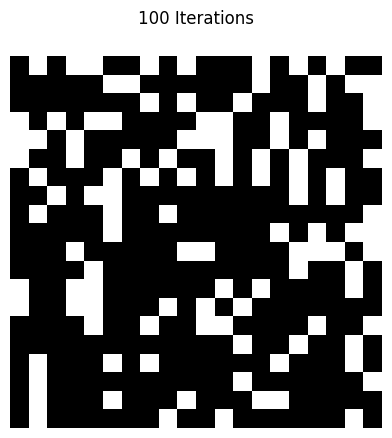

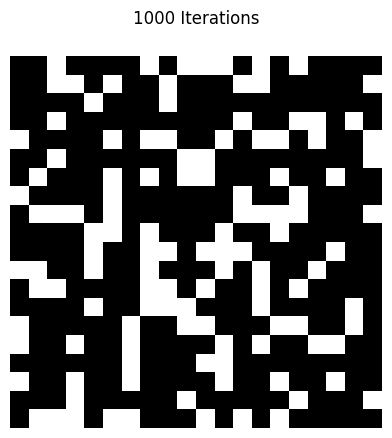

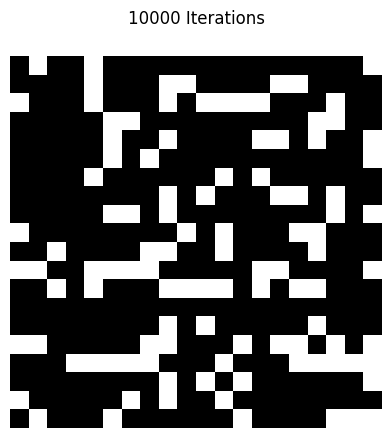

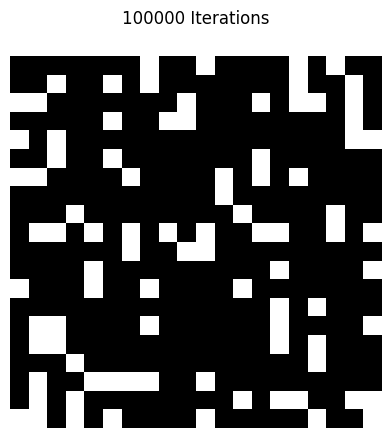

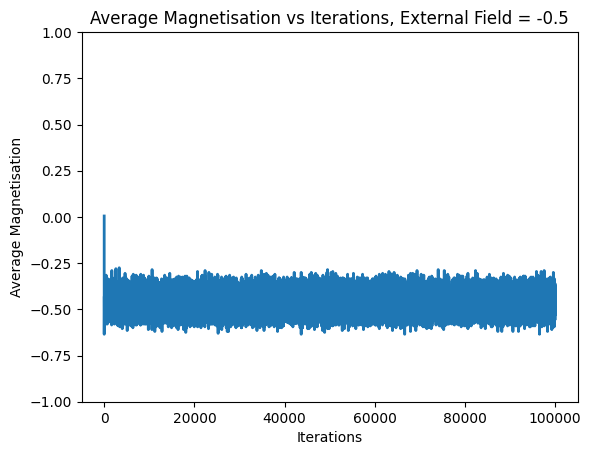

In [5]:
plt.plot(*run_N_iterations(100000, initialise_random_array(20), 0, -0.5),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = -0.5")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = 0

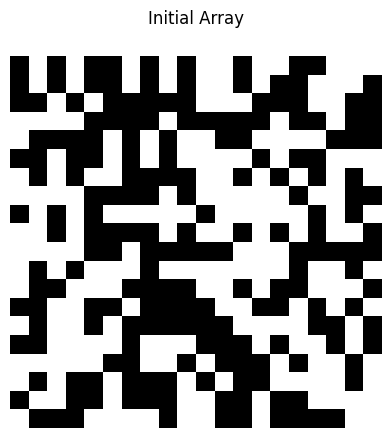

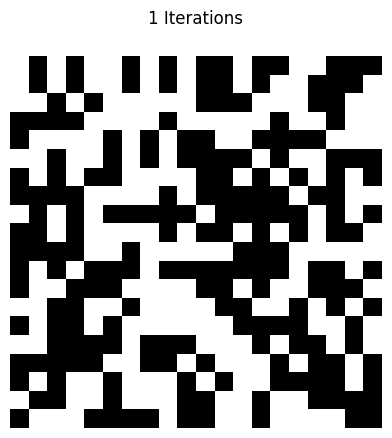

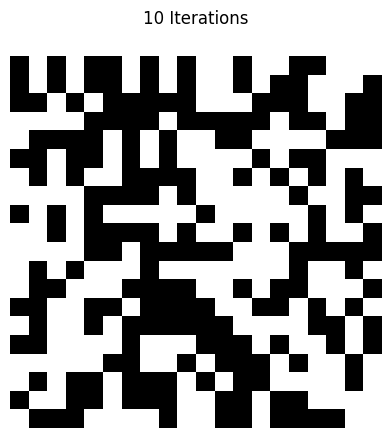

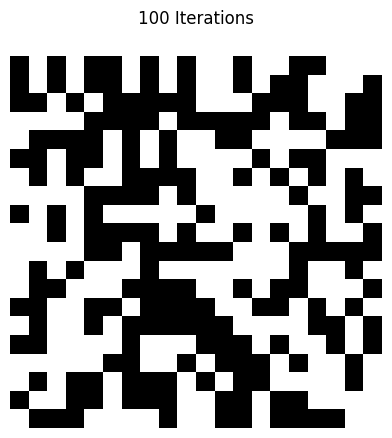

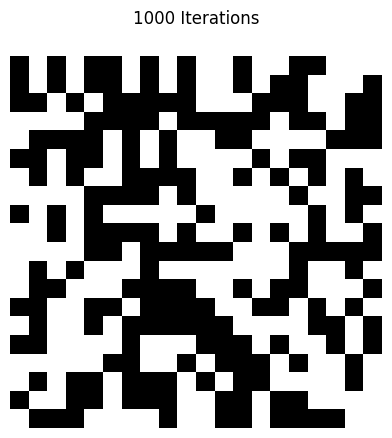

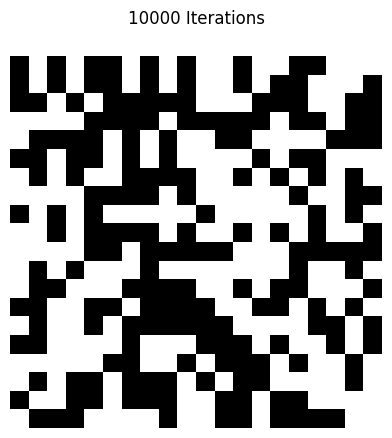

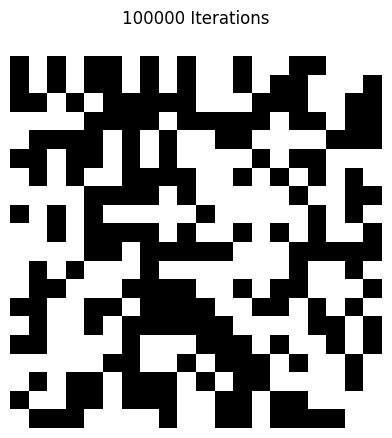

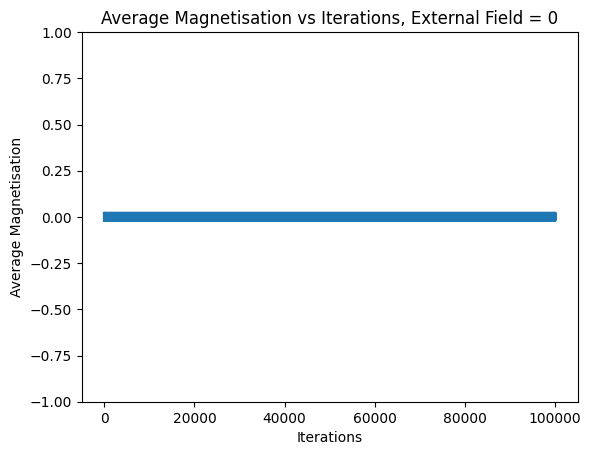

In [6]:
plt.plot(*run_N_iterations(100000, initialise_random_array(20), 0, 0),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = 0.5

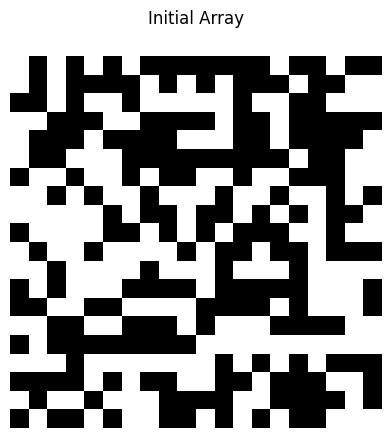

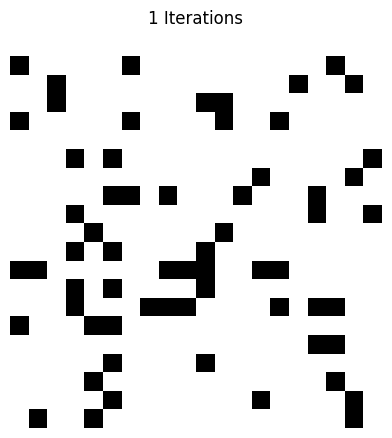

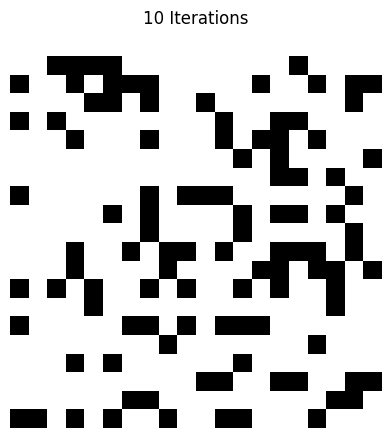

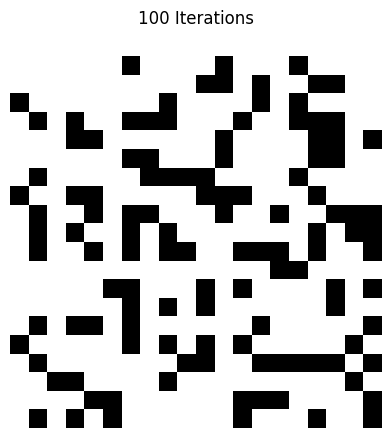

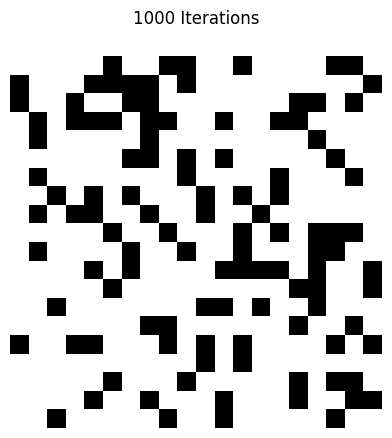

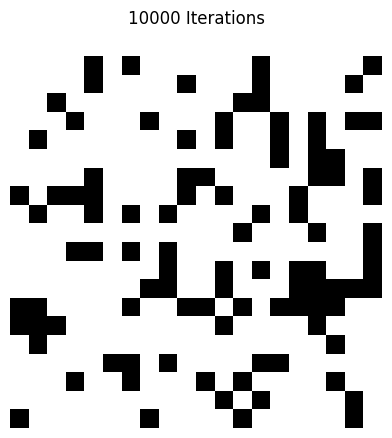

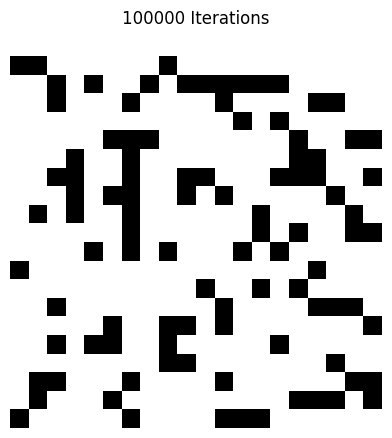

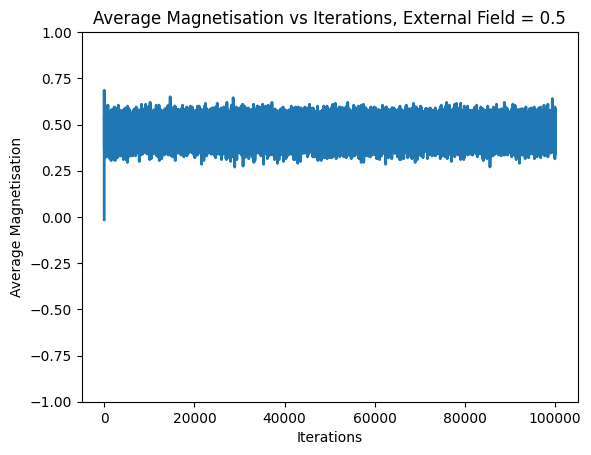

In [7]:
plt.plot(*run_N_iterations(100000, initialise_random_array(20), 0, 0.5),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0.5")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = 2

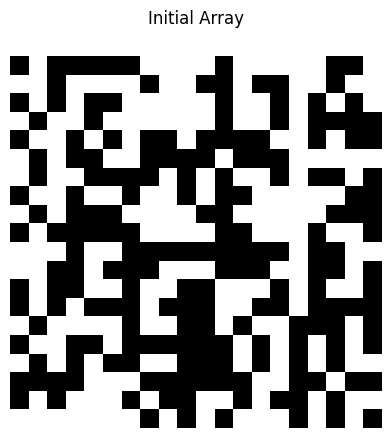

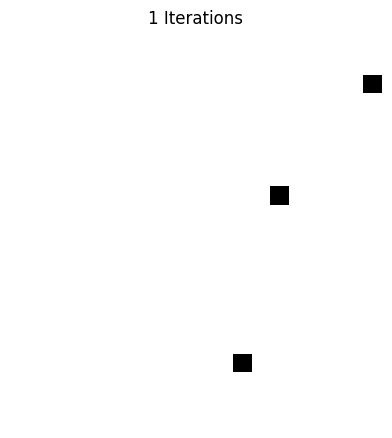

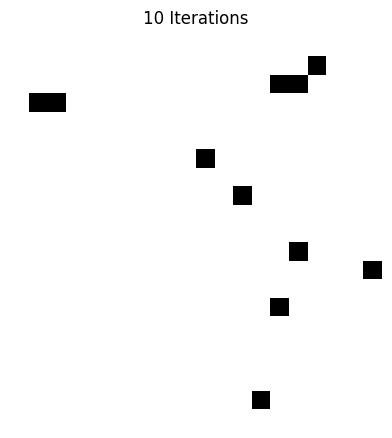

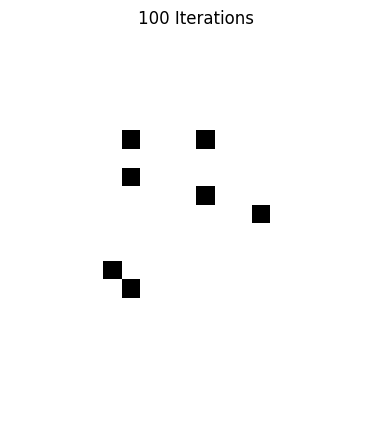

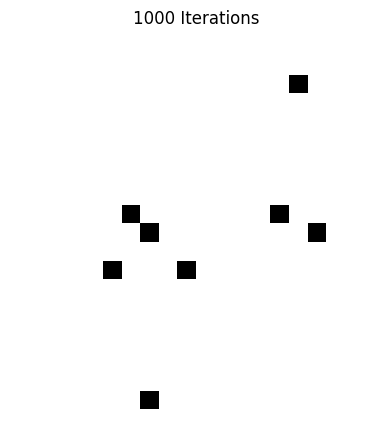

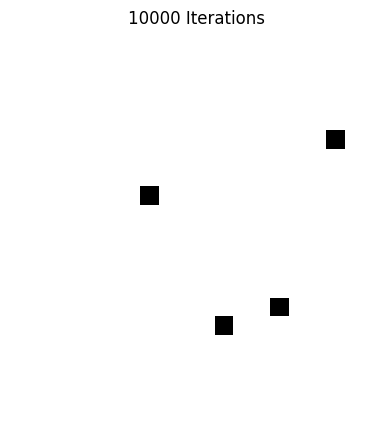

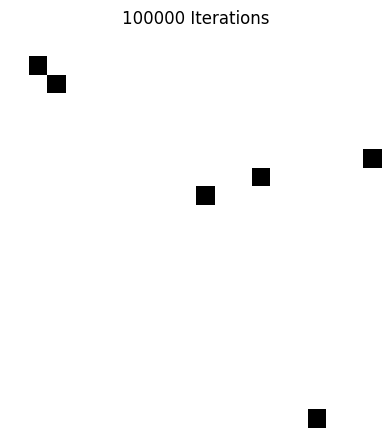

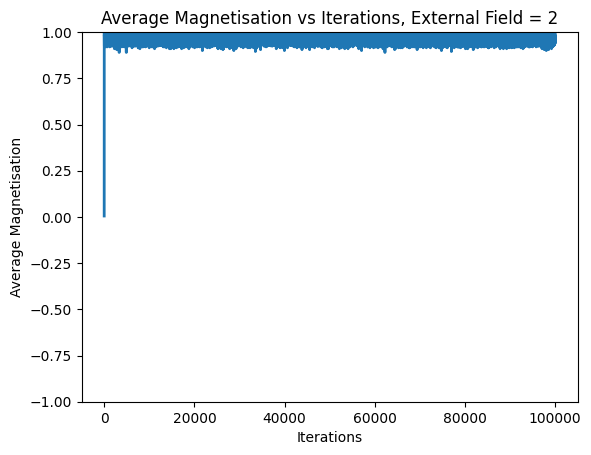

In [8]:
plt.plot(*run_N_iterations(100000, initialise_random_array(20), 0, 2),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 2")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = -3 (all up initial array)

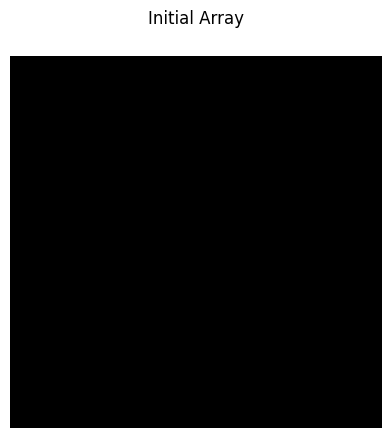

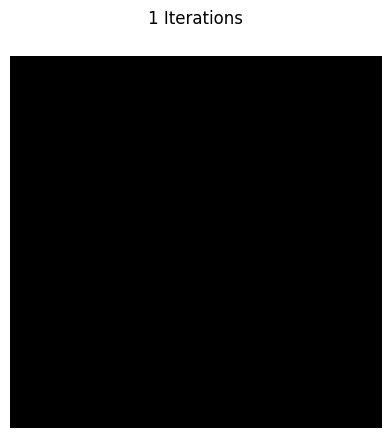

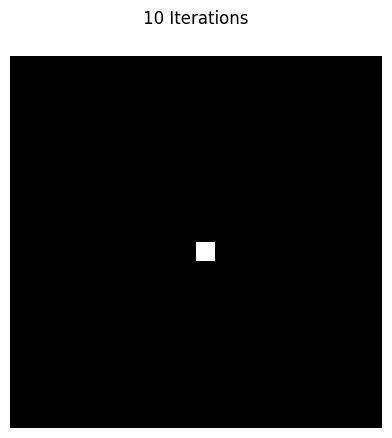

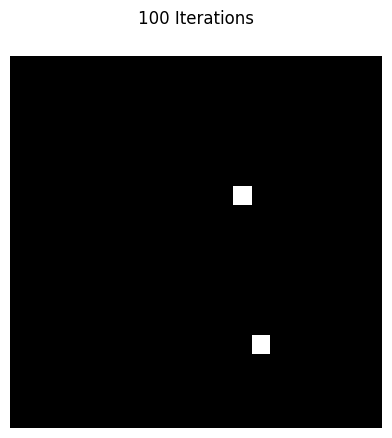

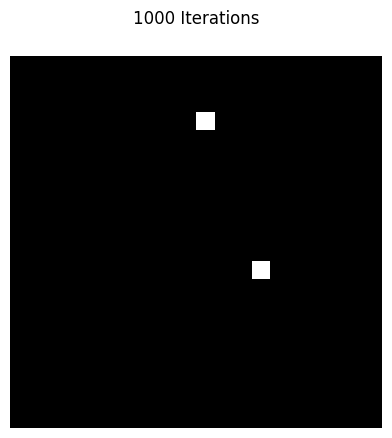

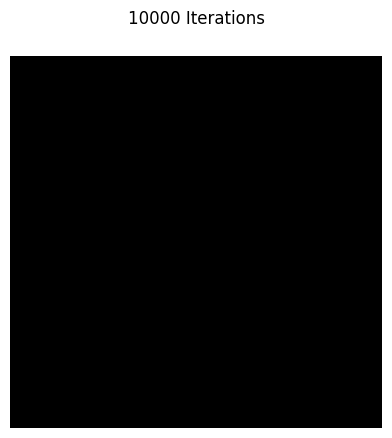

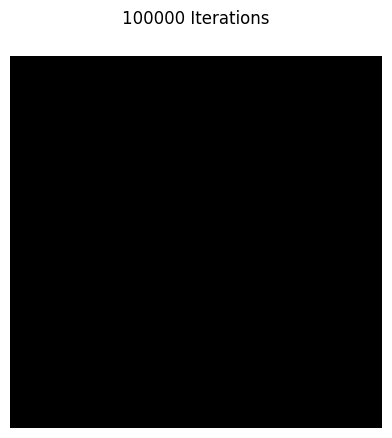

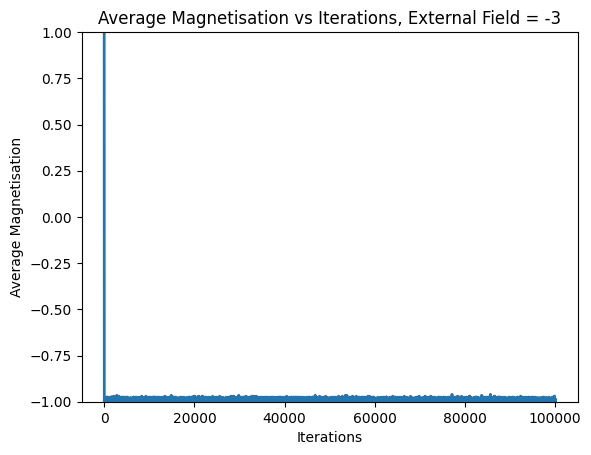

In [9]:
plt.plot(*run_N_iterations(100000, initialise_up_array(20), 0, -3),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = -3")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = 1.5 (all up initial array)

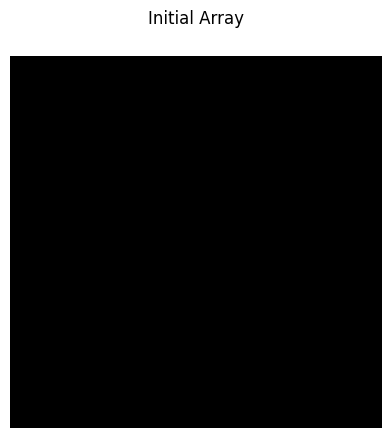

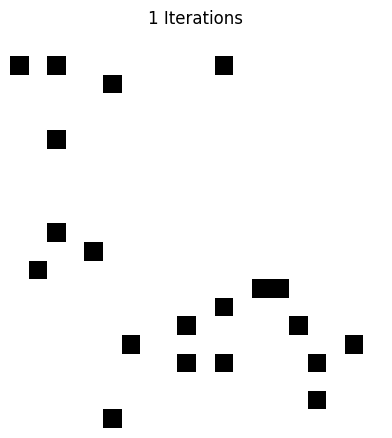

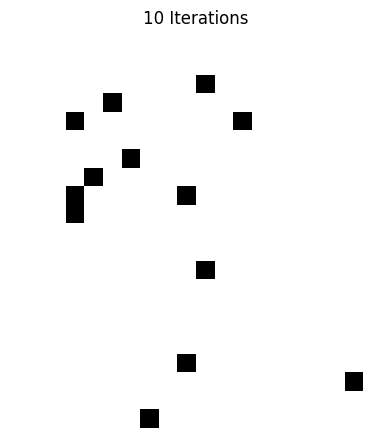

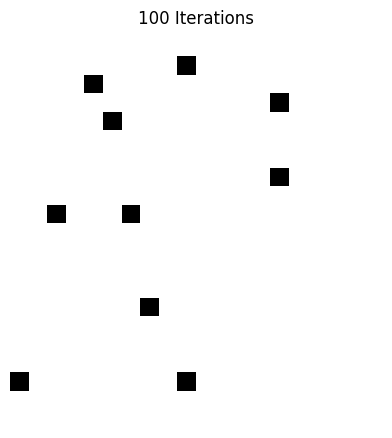

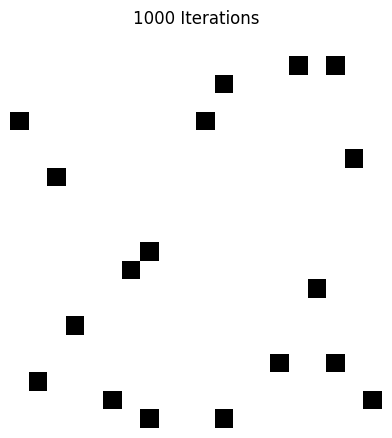

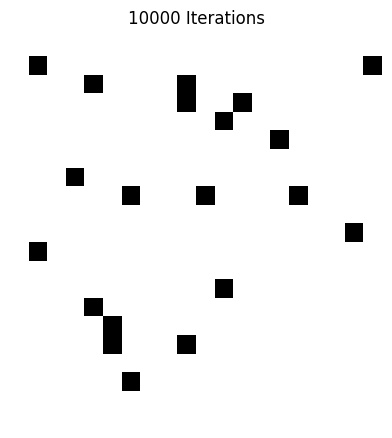

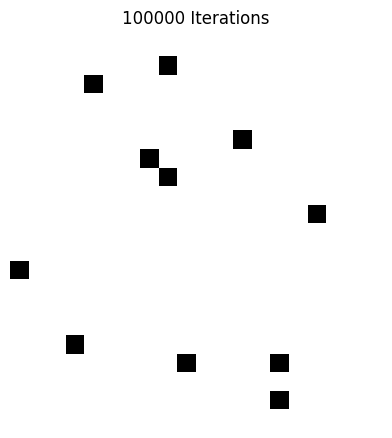

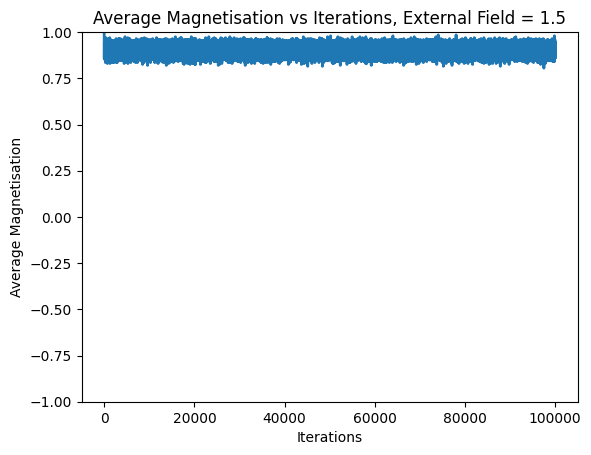

In [10]:
plt.plot(*run_N_iterations(100000, initialise_up_array(20), 0, 1.5),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 1.5")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### External Field = 0 (all up initial array)

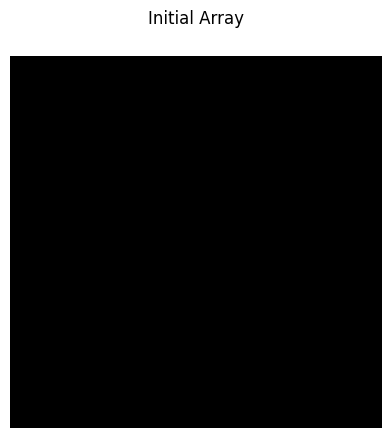

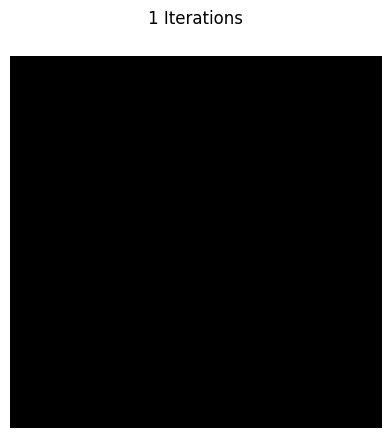

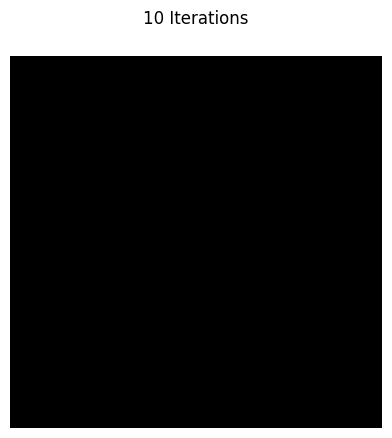

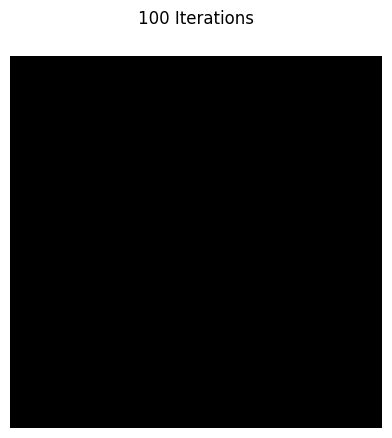

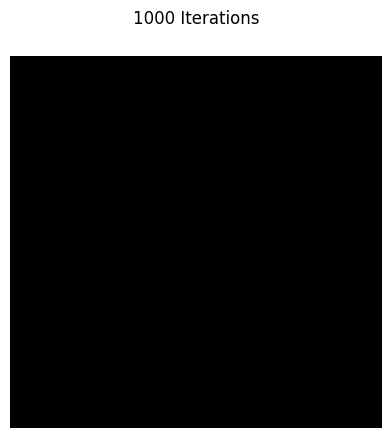

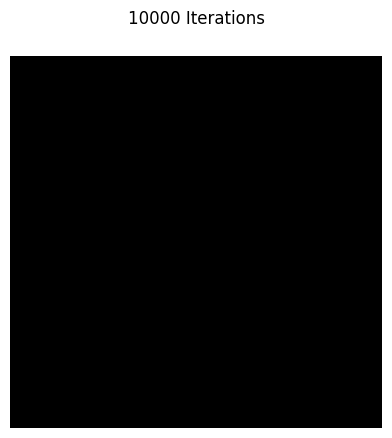

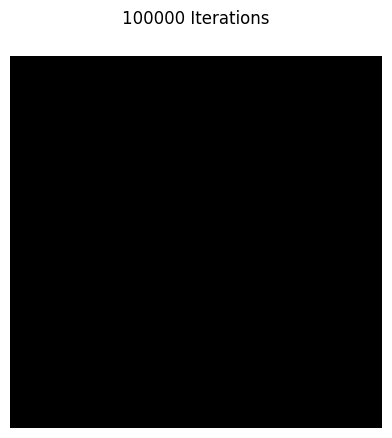

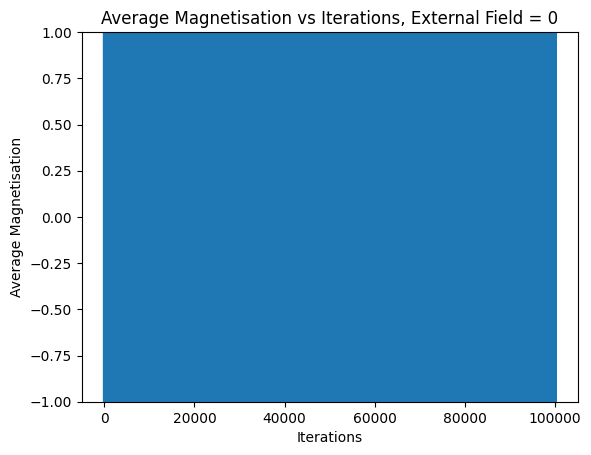

In [11]:
plt.plot(*run_N_iterations(100000, initialise_up_array(20), 0, 0),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0")
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### Comparing to analytical formula

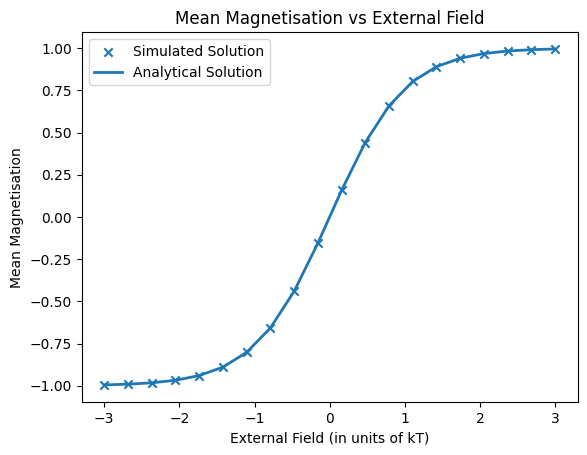

In [29]:
def anayltical_solution(external_field: float) -> float:
    """Calculates the analytical solution for the magnetisation of a 2D Ising model with no spin coupling"""
    return np.tanh(external_field)

def mean_magnetisation(N: float, input_array: np.ndarray, coupling_field: float, external_field: float
) -> float:
    """Calculates the mean magnetisation from 3N/4->N iterations, assuming system has reached equilibrium after 3N/4 iterations"""
    magnetisation = np.zeros(N + 1)
    magnetisation[0] = calc_magnetisation(input_array)
    for i in range(N):

        input_array = do_complete_iteration(input_array, coupling_field, external_field)
 
        magnetisation[i + 1] = calc_magnetisation(input_array)

    
    return np.mean(magnetisation[int(math.floor(3*N/4)):]) 

external_fields = np.linspace(-3, 3, 20)
mean_magnetisations = np.zeros(20)
for i in range(20):
    mean_magnetisations[i] = mean_magnetisation(10000,initialise_random_array(20),0,external_fields[i])
plt.scatter(external_fields,mean_magnetisations,marker='x',label="Simulated Solution")
plt.plot(external_fields,anayltical_solution(external_fields),linewidth=2,label="Analytical Solution")
plt.title("Mean Magnetisation vs External Field")
plt.xlabel("External Field (in units of kT)")
plt.ylabel("Mean Magnetisation")
plt.legend()
plt.show()


### Conclusions

BUGS IN CODE
- *Due to design of algorithm, when external field is 0 and there is no coupling, the probability of switching is 1 for every spin on the lattice*
    - *Every lattice flips for every iteration, this results in the initial array being inverted on the first iteration and then returned to on the 2nd iteration, this two state cycle repeats continuosuly.*
    - *Consequently, the average magnetisation will be 0 (as expected analytically) but a plot of magnetisation against iteration number will just rapidly fluctuate between $\pm M_0$ where $M_0$ is the intial magnetisation of the lattice.*
- *In some of the plots (such as $M_0$=1 with $\beta \mu H =-3$) the colour mapping switches from showing +1 as black in the initial array to +1 as white in subsequent iterations, this can be misleading in the plots but can be clarified by examining the plots of M vs N.*

ANALYSIS OF RESULTS
- Independent of the intial conditions the spins will eventually align in the direction of the applied field, approaching a maximum of $M=\pm1$ as the field strength increases.
- In general thermal fluctuations cause $M$ to vary with time but maintain a roughly stable average value once equilibrium is reached
- The equilibrium value corresponds to a point where thermal fluctuations are balanced by the external field
- The larger the field the smaller the thermal fluctuations are w.r.t. the field energy, consequently (as seen in the plots of M vs N) the variation of $M$ is smaller for higher field strengths.
- The larger the field the more rapidly the system approaches its equilibrium value
- In general 'larger' field means the field is larger compared to $\beta$ therefore could equally correspond to a lower temperature
- The Monte Carlo method accurately reproduces the analytical result as seen in the plot comparing analytical and simulated solution



## Core Task 2: only spin coupling
- Use algorithm with only coupling no external field
- Investigate how M varies with N, initial conditions and coupling strength

### Ferromagnetism $\beta J=0.2$ - Random initial array

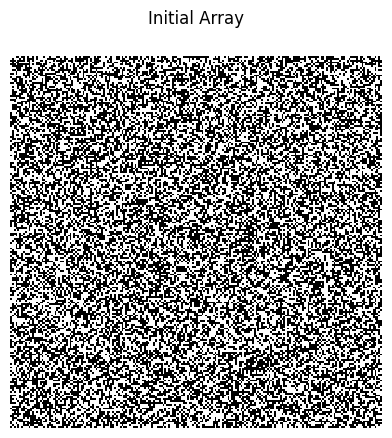

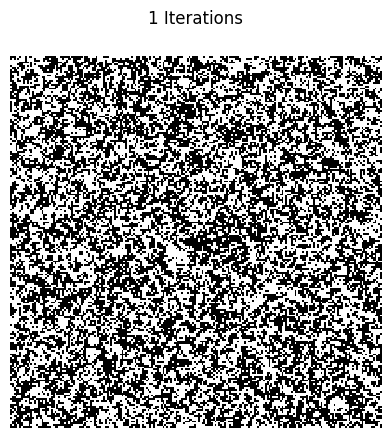

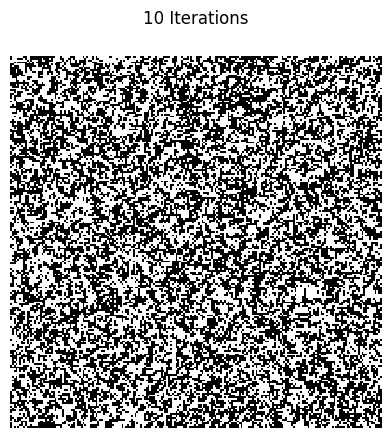

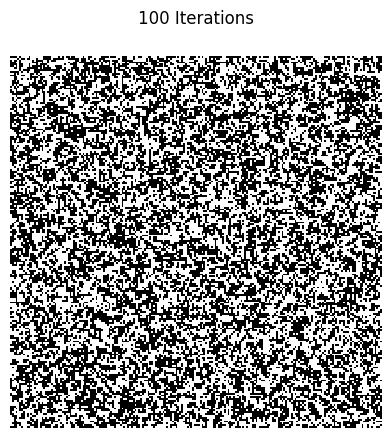

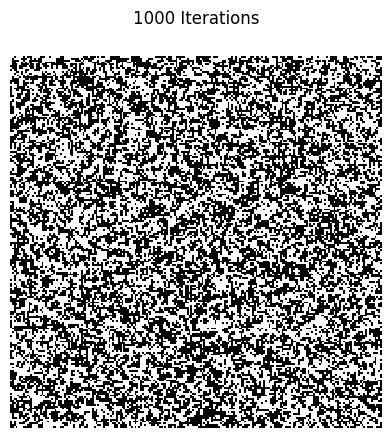

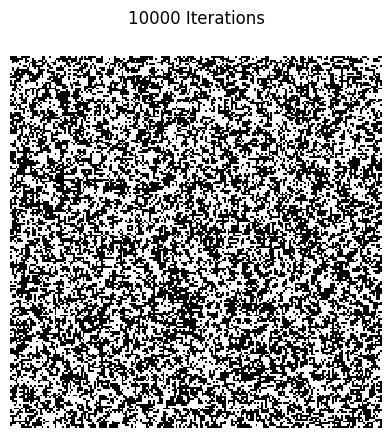

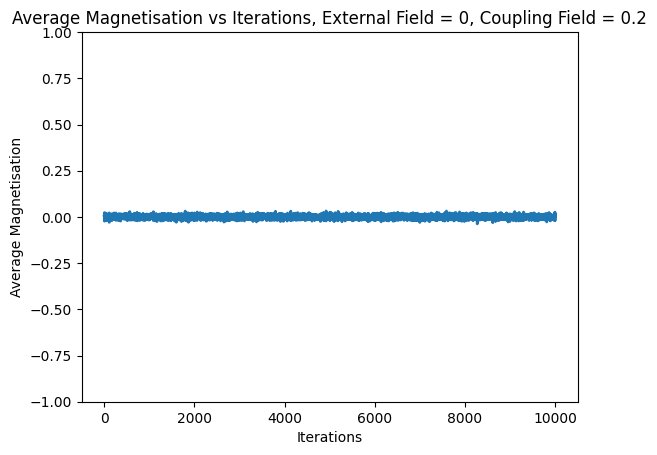

In [69]:
plt.plot(*run_N_iterations(10000, initialise_random_array(200), 0.2, 0),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0, Coupling Field = 0.2")  
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### Ferromagnetism $\beta J=0.2$ - All spin up initial array

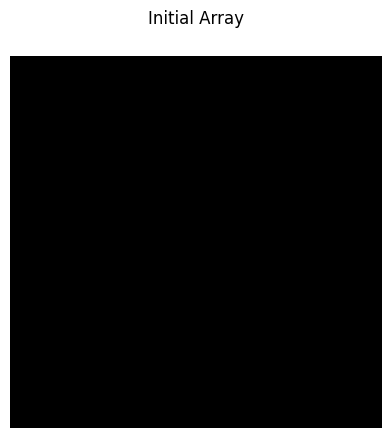

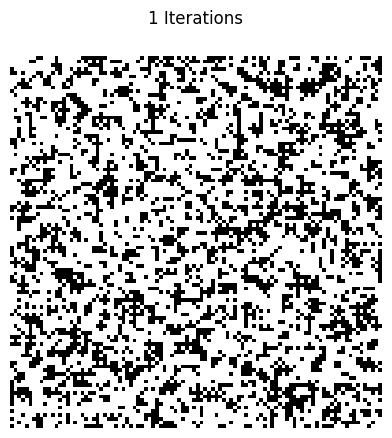

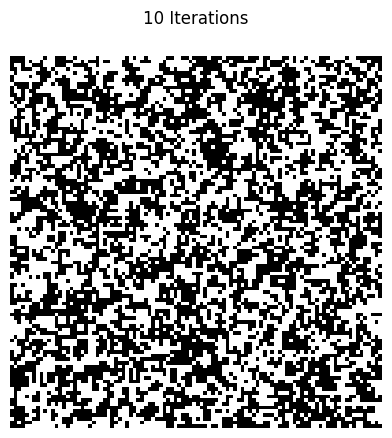

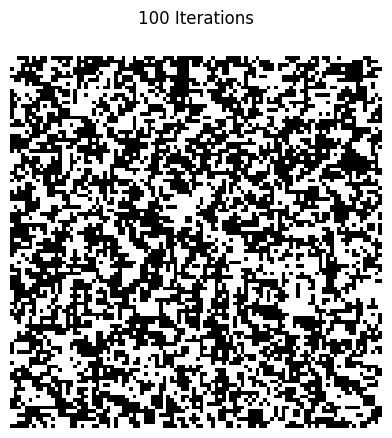

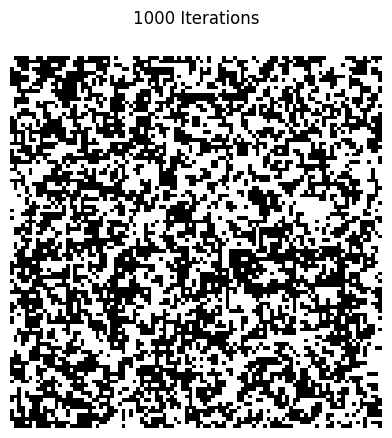

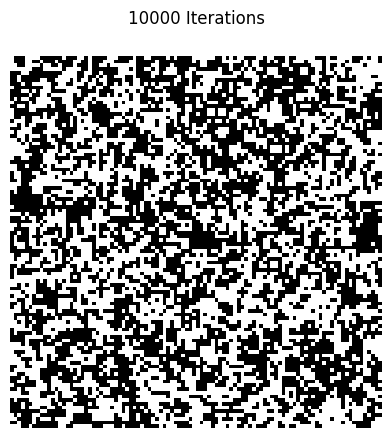

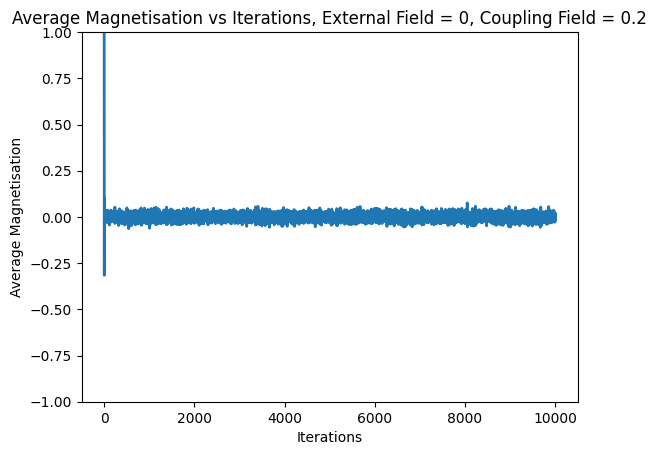

In [19]:
plt.plot(*run_N_iterations(10000, initialise_up_array(100), 0.2, 0),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0, Coupling Field = 0.2")  
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### Anti-Ferromagnetism $\beta J=-0.2$ - Random initial array

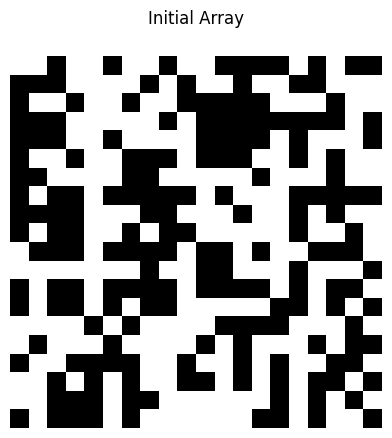

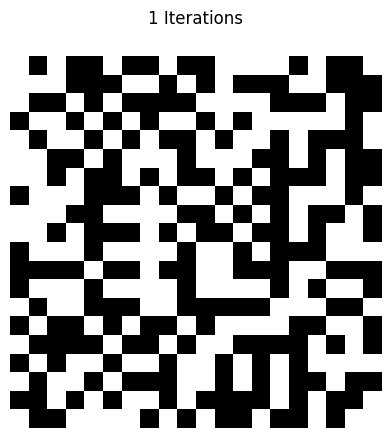

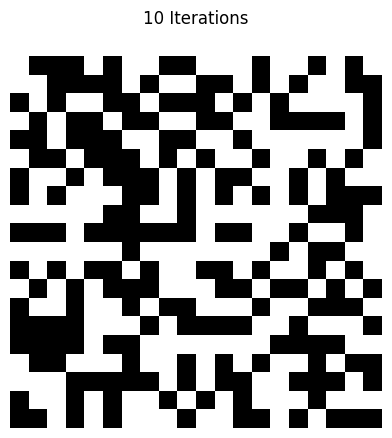

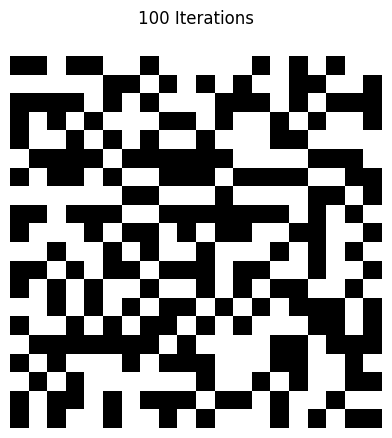

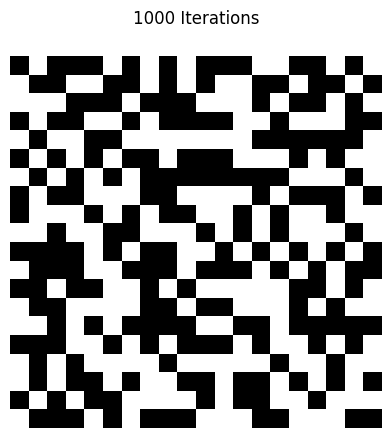

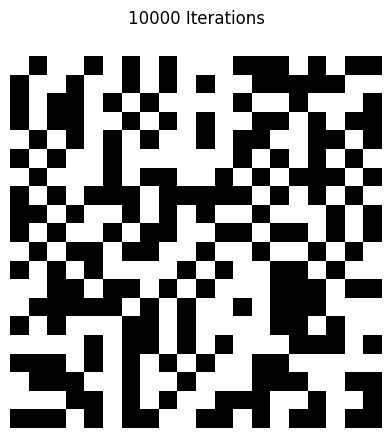

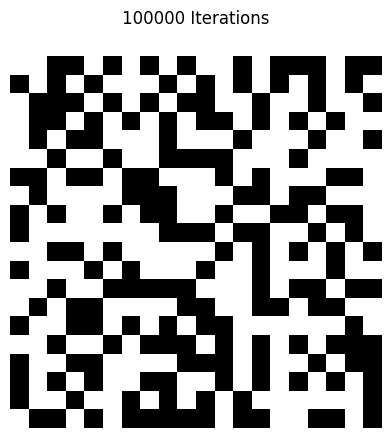

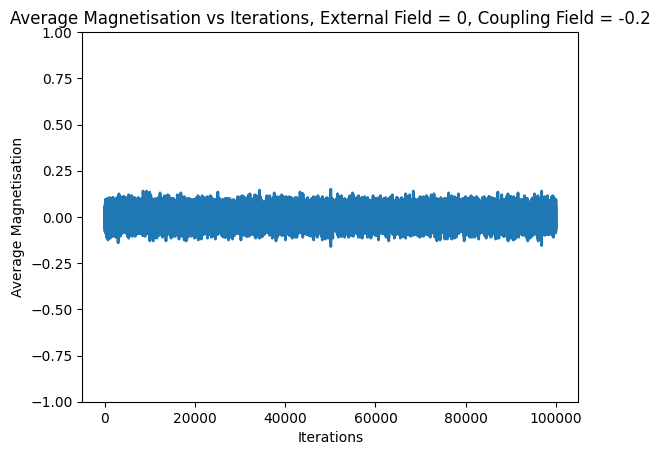

In [16]:
plt.plot(*run_N_iterations(100000, initialise_random_array(20), -0.2, 0),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0, Coupling Field = -0.2")  
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### Anti-Ferromagnetism $\beta J=-0.2$ - All spin up initial array

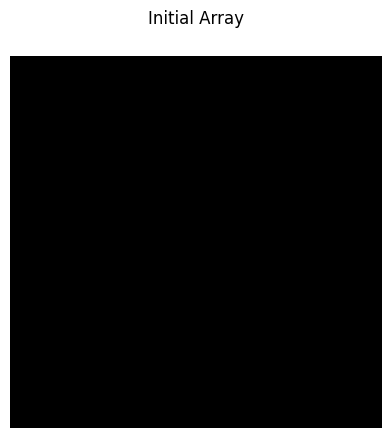

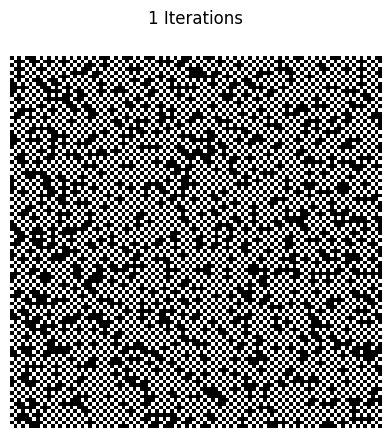

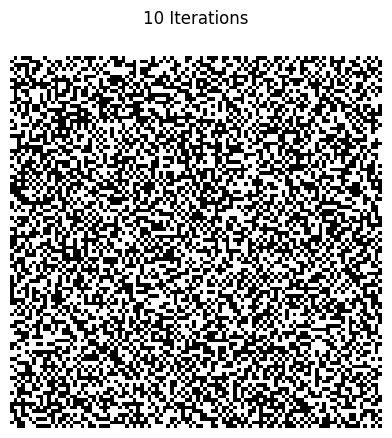

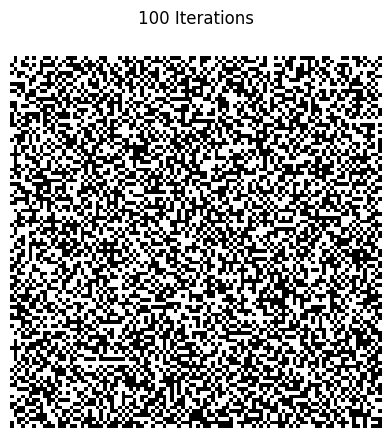

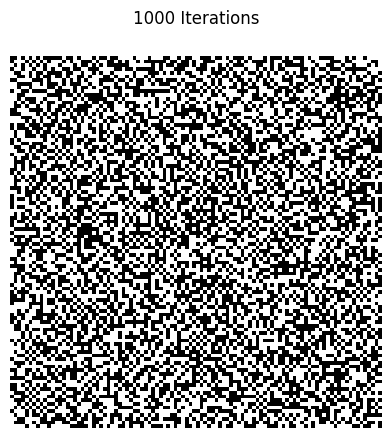

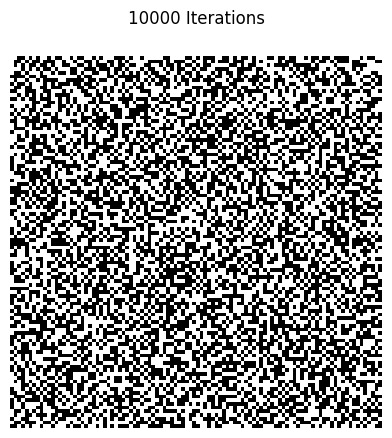

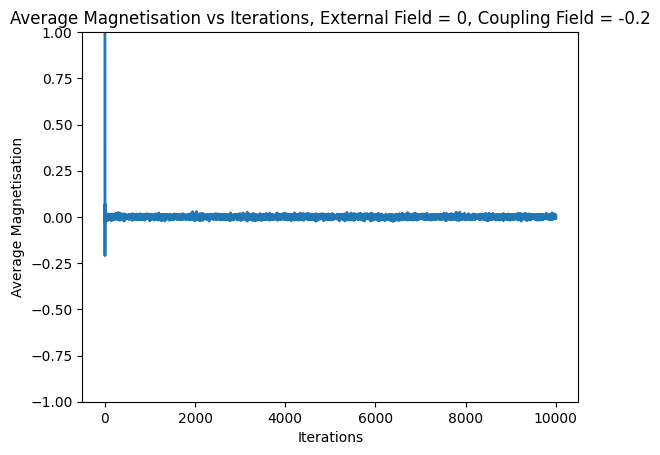

In [18]:
plt.plot(*run_N_iterations(10000, initialise_up_array(100), -0.2, 0),linewidth=2)
plt.title("Average Magnetisation vs Iterations, External Field = 0, Coupling Field = -0.2")  
plt.xlabel("Iterations")
plt.ylabel("Average Magnetisation")
plt.ylim(-1, 1)
plt.show()

### Comparing to Analytical Formula

In [53]:
def analytical_solution_coupling(reduced_temp: float) -> float:
    """analytical solution for the magnetisation of a 2D Ising model with no external field
    Intend on plotting kT/J against the mean magnetisation"""
    if reduced_temp >= 2 / (np.log(1 + np.sqrt(2))):
        return 0
    else:
        return (1 - np.sinh(2 / reduced_temp) ** (-4)) ** (1 / 8)


"""Tweaking the mean magnetisation function to more effectively calculate the mean magnetisation for a range of coupling fields"""


def mean_magnetisation_coupled(
    N: float, input_array: np.ndarray, reduced_temperature: float
) -> float:
    """Calculates the mean magnetisation of system for a given reduced temperature and returns the final equilibrium array"""
    magnetisation = np.zeros(N + 1)
    magnetisation[0] = calc_magnetisation(input_array)
    for i in range(N):

        input_array = do_complete_iteration(input_array, 1 / reduced_temperature, 0)

        magnetisation[i + 1] = calc_magnetisation(input_array)

    return np.mean(magnetisation[100:]), input_array


def magnetisations_for_temperatures(
    N: float, input_array: np.ndarray, reduced_temperatures: np.ndarray
) -> np.ndarray:
    """Calculates the mean magnetisation for a range of reduced temperatures
    starts next calculation at the final array of previous calculation so that eqm is reached faster
    """

    mean_magnetisations = np.zeros(len(reduced_temperatures))
    for i in range(len(reduced_temperatures)):
        mean_magnetisations[i] = mean_magnetisation_coupled(
            N, input_array, reduced_temperatures[i]
        )[0]
        input_array = mean_magnetisation_coupled(
            N, input_array, reduced_temperatures[i]
        )[1]
    return mean_magnetisations

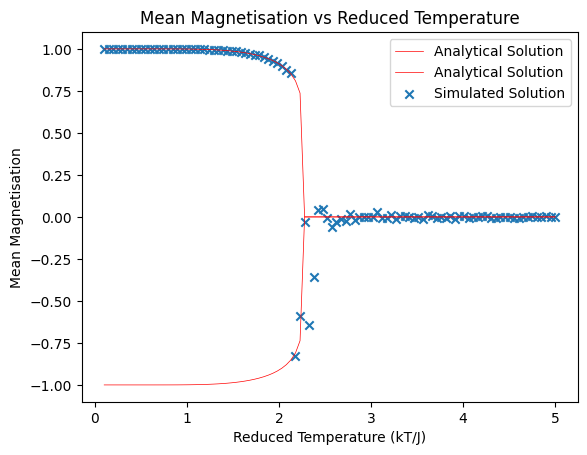

In [57]:
"""Plotting results"""
temp_range=np.linspace(0.1,5,100)
analytic_result=np.zeros(100)
for i, temp in enumerate(temp_range):
    analytic_result[i]=analytical_solution_coupling(temp)

plt.plot(temp_range,analytic_result,'r',linewidth=0.75,label="Analytical Solution")
plt.plot(temp_range,-analytic_result,'r',linewidth=0.75,label="Analytical Solution")


plt.scatter(temp_range,magnetisations_for_temperatures(1000,initialise_random_array(20),temp_range),marker='x',label="Simulated Solution")
plt.title("Mean Magnetisation vs Reduced Temperature")
plt.xlabel("Reduced Temperature (kT/J)")
plt.ylabel("Mean Magnetisation")
plt.legend()
plt.show()


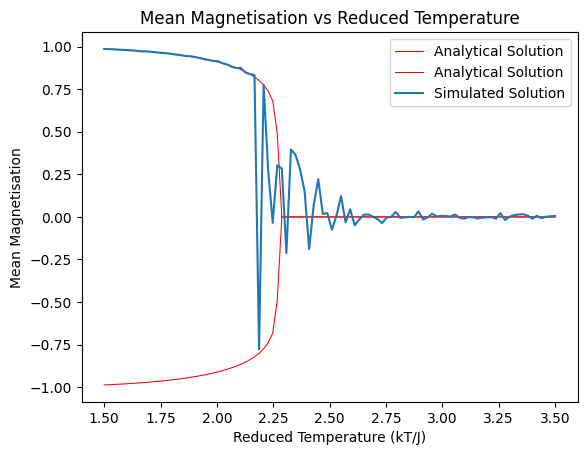

In [66]:
"""Plotting results"""
temp_range=np.linspace(1.5,3.5,100)
analytic_result_2=np.zeros(100)
for i, temp in enumerate(temp_range):
    analytic_result[i]=analytical_solution_coupling(temp)

plt.plot(temp_range,analytic_result,'r',linewidth=0.75,label="Analytical Solution")
plt.plot(temp_range,-analytic_result,'r',linewidth=0.75,label="Analytical Solution")


plt.plot(temp_range,magnetisations_for_temperatures(1000,initialise_random_array(20),temp_range),label="Simulated Solution")
plt.title("Mean Magnetisation vs Reduced Temperature")
plt.xlabel("Reduced Temperature (kT/J)")
plt.ylabel("Mean Magnetisation")
plt.legend()
plt.show()


### Conclusions
- For both the ferromagnetic and anti-ferromagnetic systems, $\beta J$ is such that T is above the critical temperature 
- Therefore, as expected analytically, the average magnetisation of both systems tends to 0
- Characteristic behaviour is more easily observed by increasing size of array at the expense of number of iterations:
    - For ferromagnet, alignment of neighbouring spins is favourable. Starting from a random mixed initial arrangement, different spins separate and cluster into same-spin groups, forming a two phase system with +1 dominated domains and -1 dominated domains.
    - For anti-ferromagnet, anti-alignment is favourable. From an initial all-up state, checkerboard patterns emerge and spread through the material, different spins are intermixed in one single state containing +1 and -1. 
    - Both scenarios show zero net magnetisation but have different microstructures.

- The Monte Carlo method accurately approximates the analytical solution.
- As the temperature approaches $T_c$ from above the size of fluctuations in $M$ grows.
- Below $T_c$ two separate solutions can exist (spontaneous symmetry breaking), with the majority of spins either aligned in the +1 or -1 direction.


## Supplementary Task
- Calculate the standard deviation of fluctuations in system energy
- Plot heat capacity against temperature for a variety of lattice sizes


1. Create an initial array and update it a certain number of times until thermal equilibrium has been reached
2. Continue to evolve array and record energy for each iteration
3. Calculate the deviation of the energy
4. Use this to calculate C as a function of reduced temperature


In [92]:
def calculate_energy(input_array: np.ndarray, reduced_temperature: float) -> float:
    """Calculates the energy of the input array for no external field"""
    coupling_field = 1 / reduced_temperature
    k_matrix = generate_k_matrix(input_array)
    return -np.sum(-1 * coupling_field * np.multiply(input_array, k_matrix))


def energy_deviation(
    input_array: np.ndarray, reduced_temperature: float, sample_size: float
) -> float:
    """Thermalises an initial input array, then calculates energy for a variety of microstates (sample size) and returns the standard deviation"""
    energies = np.zeros(sample_size)  # array to store energies
    
    for i in range(500):  # enough steps to reach equilibrium
        input_array = do_complete_iteration(input_array, 1 / reduced_temperature, 0)
    
    for j in range(sample_size):
        energies[j] = calculate_energy(input_array, reduced_temperature)
        input_array = do_complete_iteration(input_array, 1 / reduced_temperature, 0)
    
    
    return np.std(energies)


def energy_deviation_for_temperatures(input_array: np.ndarray,
    reduced_temperatures: np.ndarray, sample_size: float
) -> np.ndarray:
    """Calculates the standard deviation of the energy for a range of reduced temperatures"""
    energy_deviations = np.zeros(len(reduced_temperatures))
    for i, temp in enumerate(reduced_temperatures):
        energy_deviations[i] = energy_deviation(
            input_array, temp, sample_size
        )
    '''Encountering 0s because the standard deviations are so small'''
    energy_deviations[energy_deviations == 0] = np.nan
    return energy_deviations

def specific_heat(energy_deviations: np.ndarray, reduced_temperature: np.ndarray) -> np.ndarray:
    """Calculates the specific heat from the energy deviation"""
    return energy_deviations / reduced_temperature
 

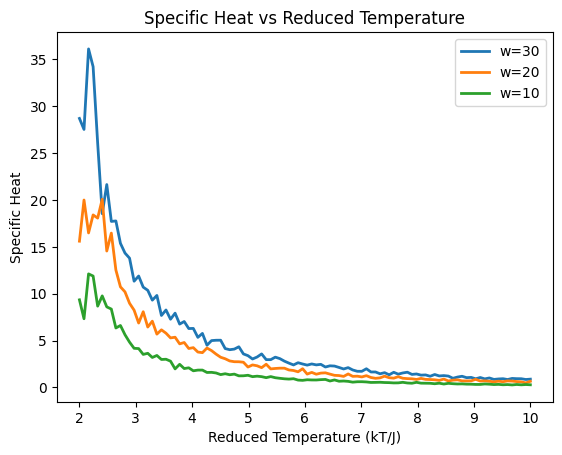

In [97]:
"""""Plotting Results"""
w1=30
w2=20
w3=10
new_temp_range=np.linspace(2,10,100)

plt.plot(new_temp_range,specific_heat(energy_deviation_for_temperatures(initialise_random_array(w1),new_temp_range,100),new_temp_range),linewidth=2,label="w=30")
plt.plot(new_temp_range,specific_heat(energy_deviation_for_temperatures(initialise_random_array(w2),new_temp_range,100),new_temp_range),linewidth=2,label="w=20")
plt.plot(new_temp_range,specific_heat(energy_deviation_for_temperatures(initialise_random_array(w3),new_temp_range,100),new_temp_range),linewidth=2,label="w=10")
plt.title("Specific Heat vs Reduced Temperature")
plt.xlabel("Reduced Temperature (kT/J)")
plt.ylabel("Specific Heat")
plt.legend()
plt.show()





### Conclusions
- As T approaches the $T_C$ phase transition, correlation lengths grow and are eventually capped by the dimensions of the substance i.e. the size of the array.
- Larger correlation lengths lead to greater fluctuations 
- Consequently larger systems can exhibit greater fluctuations near $T_C$ and will therefore have a larger heat capacity
- The simulated data agrees with this result, it shows heat capacity rapidly rising as T gets close to the critical point and shows that larger arrays leads to an increased peak in the heat capacity 
